<a href="https://colab.research.google.com/github/leoroman1/DL_project/blob/main/DL_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# connect to your drive with the dataset folder

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# set the paths of the tar dataset and the destination of the extracted dataset ONLY IF NEEDED

tar_path = '/content/drive/MyDrive/Task01_BrainTumour.tar'
extract_path = '/content/drive/MyDrive/Task01_BrainTumour'


In [ ]:
# dataset tar extraction ONLY IF NEEDED

import tarfile
from tqdm import tqdm
import os

# Paths (modify as needed)
tar_path = '/content/drive/MyDrive/Task01_BrainTumour.tar'
extract_path = '/content/drive/MyDrive/Task01_BrainTumour'

# Ensure output directory exists
os.makedirs(extract_path, exist_ok=True)

# Open and extract with progress bar
with tarfile.open(tar_path) as tar:
    members = tar.getmembers()
    print(f"Extracting {len(members)} files to: {extract_path}")
    for member in tqdm(members, desc="Extracting", unit="file"):
        tar.extract(member, path=extract_path)

print("✅ Extraction complete.")


Extracting 1277 files to: /content/drive/MyDrive/Task01_BrainTumour


Extracting: 100%|██████████| 1277/1277 [02:00<00:00, 10.61file/s]

✅ Extraction complete.


In [ ]:
data_dir = '/content/drive/MyDrive/Task01_BrainTumour/Task01_BrainTumour'  # change if needed
image_dir = f'{data_dir}/imagesTr'
label_dir = f'{data_dir}/labelsTr'

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Define a function to load the image and label volumes from .nii.gz files
def load_volume(img_path, lbl_path):
    # Load the image data using nibabel and get the numpy array
    img = nib.load(img_path).get_fdata()   # Expected shape: (Height, Width, Depth, Modalities=4)
    # Load the label data using nibabel and get the numpy array
    lbl = nib.load(lbl_path).get_fdata()   # Expected shape: (Height, Width, Depth)
    # Convert the image data to float32 and the label data to uint8 for consistency
    return img.astype(np.float32), lbl.astype(np.uint8)

# Define the file paths for a sample image and its corresponding label
sample_image = f'{image_dir}/BRATS_001.nii.gz'
sample_label = f'{label_dir}/BRATS_001.nii.gz'

# Load the sample image and label using the defined function
x, y = load_volume(sample_image, sample_label)

# Print the shapes of the loaded image and label arrays
print("Image shape:", x.shape)
print("Label shape:", y.shape)

Image shape: (240, 240, 155, 4)
Label shape: (240, 240, 155)


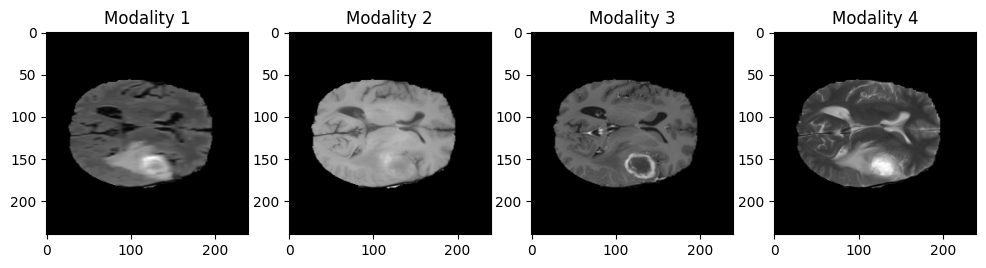

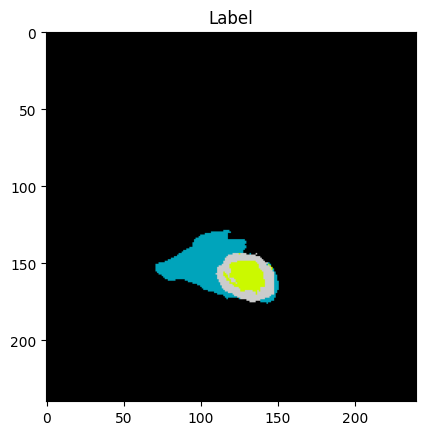

In [ ]:
# Create figure for modalities
plt.figure(figsize=(12, 4))

# Loop through modalities
for i in range(4):
    # Create subplot
    plt.subplot(1, 4, i+1)
    # Display middle slice of current modality
    plt.imshow(x[..., x.shape[2]//2, i], cmap='gray')
    # Set modality title
    plt.title(f'Modality {i+1}')

# Show modality plots
plt.show()

# Display middle slice of label
plt.imshow(y[..., y.shape[2]//2], cmap='nipy_spectral')
# Set label title
plt.title('Label')

# Show label plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt                  # For plotting
import ipywidgets as widgets                    # For interactive sliders in Jupyter
from IPython.display import display             # To display widgets in output cell

def show_mri_with_labels(volume, label, modality=0, axis=2, alpha=0.4):
    """
    Interactive visualization of MRI slices with segmentation labels.

    Parameters:
    - volume: 4D numpy array (H, W, D, modalities)
    - label: 3D numpy array (H, W, D) with segmentation labels
    - modality: index of the modality to visualize
    - axis: axis along which to slice (0, 1, or 2)
    - alpha: transparency level for label overlay
    """
    assert volume.shape[:3] == label.shape, "Volume and label shape mismatch"
    max_idx = volume.shape[axis] - 1  # Get the number of slices along chosen axis

    def view_slice(i):
        plt.figure(figsize=(6, 6))  # Set figure size

        # Extract the image and label slice based on selected axis
        if axis == 0:
            img = volume[i, :, :, modality]
            lbl = label[i, :, :]
        elif axis == 1:
            img = volume[:, i, :, modality]
            lbl = label[:, i, :]
        else:
            img = volume[:, :, i, modality]
            lbl = label[:, :, i]

        # Display grayscale image with label overlay
        plt.imshow(img, cmap='gray')
        plt.imshow(lbl, cmap='nipy_spectral', alpha=alpha)  # Overlay labels with transparency
        plt.axis('off')
        plt.title(f'Slice {i} — Modality {modality}')
        plt.show()

    # Create an interactive slider to scroll through slices
    slider = widgets.IntSlider(min=0, max=max_idx, step=1, value=max_idx // 2)
    display(widgets.interact(view_slice, i=slider))  # Link slider to view_slice function

# Example usage:
show_mri_with_labels(x, y, modality=0, axis=2)  # Visualize modality 0 along the axial axis





interactive(children=(IntSlider(value=77, description='i', max=154), Output()), _dom_classes=('widget-interact…

<function __main__.show_mri_with_labels.<locals>.view_slice(i)>

In [ ]:
# === SETUP ===

import os, glob
import nibabel as nib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === DATASET CLASS ===

class BraTSDataset(Dataset):
    def __init__(self, image_paths, label_paths, patch_size=(128, 128, 72)):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.patch_size = patch_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = nib.load(self.image_paths[idx]).get_fdata().astype(np.float32)  # (H, W, D, 4)
        lbl = nib.load(self.label_paths[idx]).get_fdata().astype(np.uint8)    # (H, W, D)

        # Center crop
        H, W, D = lbl.shape
        ph, pw, pd = self.patch_size
        sh = (H - ph) // 2
        sw = (W - pw) // 2
        sd = (D - pd) // 2

        img = img[sh:sh+ph, sw:sw+pw, sd:sd+pd, :]
        lbl = lbl[sh:sh+ph, sw:sw+pw, sd:sd+pd]

        # Convert to PyTorch tensors: (C, H, W, D) and (H, W, D)
        img = torch.tensor(img).permute(3, 0, 1, 2)
        lbl = torch.tensor(lbl, dtype=torch.long)
        return img, lbl

# === SIMPLE 3D UNET ===

class Simple3DUNet(nn.Module):
    def __init__(self, in_channels=4, out_classes=4):
        super().__init__()
        self.enc1 = self.conv_block(in_channels, 16)
        self.enc2 = self.conv_block(16, 32)
        self.pool = nn.MaxPool3d(2)

        self.bottleneck = self.conv_block(32, 64)

        self.up1 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(64, 32)

        self.up2 = nn.ConvTranspose3d(32, 16, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(32, 16)

        self.out_conv = nn.Conv3d(16, out_classes, kernel_size=1)

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv3d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(),
            nn.Conv3d(out_ch, out_ch, 3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        b = self.bottleneck(self.pool(e2))
        d1 = self.up1(b)
        d1 = self.dec1(torch.cat([d1, e2], dim=1))
        d2 = self.up2(d1)
        d2 = self.dec2(torch.cat([d2, e1], dim=1))
        return self.out_conv(d2)




In [ ]:
# === LOSS FUNCTIONS ===

# Class weights: adjust these based on label distribution
class_weights = torch.tensor([0.05, 0.5, 0.8, 1.0]).to(device)

def dice_loss(pred, target, smooth=1e-5):
    pred = F.softmax(pred, dim=1)
    target_onehot = F.one_hot(target, num_classes=pred.shape[1]).permute(0, 4, 1, 2, 3)
    target_onehot = target_onehot.float()
    intersection = (pred * target_onehot).sum(dim=(2, 3, 4))
    union = pred.sum(dim=(2, 3, 4)) + target_onehot.sum(dim=(2, 3, 4))
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

def combined_loss(pred, target):
    ce = F.cross_entropy(pred, target, weight=class_weights)
    dsc = dice_loss(pred, target)
    return ce + dsc

# === LOAD FILES ===

image_paths = sorted(glob.glob(os.path.join(image_dir, "*.nii.gz")))
label_paths = sorted(glob.glob(os.path.join(label_dir, "*.nii.gz")))

# Use a subset for demonstration
image_paths = image_paths[:10]
label_paths = label_paths[:10]

train_dataset = BraTSDataset(image_paths, label_paths)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# === TRAINING LOOP ===

model = Simple3DUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = combined_loss(out, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss/len(train_loader):.4f}")

Epoch 1/10 - Loss: 3.0092
Epoch 2/10 - Loss: 2.3414
Epoch 3/10 - Loss: 2.0212
Epoch 4/10 - Loss: 1.7860
Epoch 5/10 - Loss: 1.6943
Epoch 6/10 - Loss: 1.5233
Epoch 7/10 - Loss: 1.4376
Epoch 8/10 - Loss: 1.3975
Epoch 9/10 - Loss: 1.3505
Epoch 10/10 - Loss: 1.2910


In [ ]:
# Path to save the model
save_path = '/content/drive/MyDrive/brats_model_1.pth'  # You can change the filename/path

# Save state_dict (model parameters only)
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")


Model saved to /content/drive/MyDrive/brats_model_1.pth


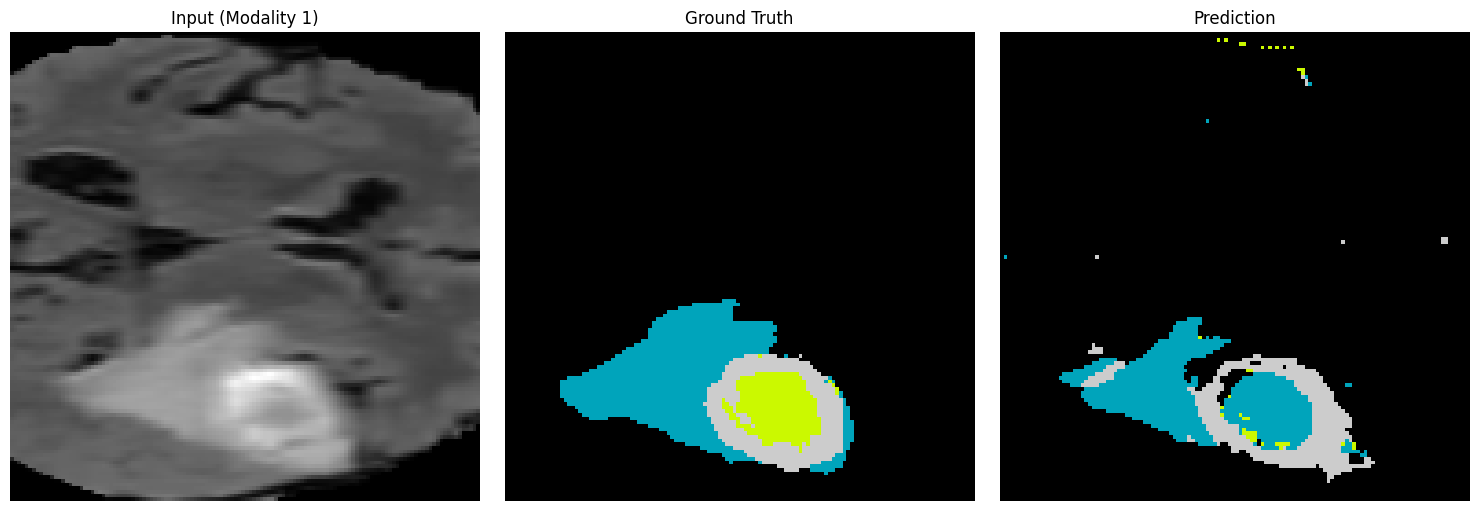

In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

# === EVALUATION AND PREDICTION ===

model.eval()  # Set model to evaluation mode

# Pick a sample image from dataset
with torch.no_grad():
    x_sample, y_true = train_dataset[0]  # Get first sample
    x_sample = x_sample.unsqueeze(0).to(device)  # Add batch dimension

    # Predict
    logits = model(x_sample)
    preds = torch.argmax(F.softmax(logits, dim=1), dim=1).squeeze(0).cpu().numpy()  # shape: (H, W, D)
    y_true = y_true.numpy()  # ground truth (H, W, D)

# === SLICE-WISE VISUALIZATION ===

slice_idx = preds.shape[2] // 2  # Middle axial slice

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(x_sample[0, 0, :, :, slice_idx].cpu(), cmap='gray')
axs[0].set_title("Input (Modality 1)")

axs[1].imshow(y_true[:, :, slice_idx], cmap='nipy_spectral')
axs[1].set_title("Ground Truth")

axs[2].imshow(preds[:, :, slice_idx], cmap='nipy_spectral')
axs[2].set_title("Prediction")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import ipywidgets as widgets
from IPython.display import display

def view_slice(i):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(x_sample[0, 0, :, :, i].cpu(), cmap='gray')
    axs[0].set_title("Input")
    axs[1].imshow(y_true[:, :, i], cmap='nipy_spectral')
    axs[1].set_title("Ground Truth")
    axs[2].imshow(preds[:, :, i], cmap='nipy_spectral')
    axs[2].set_title("Prediction")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

slider = widgets.IntSlider(min=0, max=preds.shape[2]-1, step=1, value=preds.shape[2]//2)
widgets.interact(view_slice, i=slider)


interactive(children=(IntSlider(value=36, description='i', max=71), Output()), _dom_classes=('widget-interact'…

<function __main__.view_slice(i)>

In [ ]:
#to load model data
model.load_state_dict(torch.load("/content/drive/MyDrive/path_to/model_weights.pth"))


In [ ]:
# PREPROCESSING FUNCTIONS

# to do: normalizatio
# crop and back to original padding (capire se ha senso)

In [ ]:
# === SETUP WITH PREPROCESSING ===

import os, glob
import nibabel as nib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === DATASET CLASS ===

class BraTSDataset(Dataset):
    def __init__(self, image_paths, label_paths, patch_size=(128, 128, 72)):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.patch_size = patch_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = nib.load(self.image_paths[idx]).get_fdata().astype(np.float32)  # (H, W, D, 4)
        lbl = nib.load(self.label_paths[idx]).get_fdata().astype(np.uint8)    # (H, W, D)

        # Center crop
        H, W, D = lbl.shape
        ph, pw, pd = self.patch_size
        sh = (H - ph) // 2
        sw = (W - pw) // 2
        sd = (D - pd) // 2

        img = img[sh:sh+ph, sw:sw+pw, sd:sd+pd, :]
        lbl = lbl[sh:sh+ph, sw:sw+pw, sd:sd+pd]

        # Convert to PyTorch tensors: (C, H, W, D) and (H, W, D)
        img = torch.tensor(img).permute(3, 0, 1, 2)
        lbl = torch.tensor(lbl, dtype=torch.long)
        return img, lbl

# === SIMPLE 3D UNET ===

class Simple3DUNet(nn.Module):
    def __init__(self, in_channels=4, out_classes=4):
        super().__init__()
        self.enc1 = self.conv_block(in_channels, 16)
        self.enc2 = self.conv_block(16, 32)
        self.pool = nn.MaxPool3d(2)

        self.bottleneck = self.conv_block(32, 64)

        self.up1 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(64, 32)

        self.up2 = nn.ConvTranspose3d(32, 16, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(32, 16)

        self.out_conv = nn.Conv3d(16, out_classes, kernel_size=1)

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv3d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(),
            nn.Conv3d(out_ch, out_ch, 3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        b = self.bottleneck(self.pool(e2))
        d1 = self.up1(b)
        d1 = self.dec1(torch.cat([d1, e2], dim=1))
        d2 = self.up2(d1)
        d2 = self.dec2(torch.cat([d2, e1], dim=1))
        return self.out_conv(d2)